In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from airsea.windstress import stress
from matplotlib import mlab
import scipy.signal as signal
from physoce import tseries as tsx

def rot(u,v,theta):
    w = u + 1j*v
    ang = theta*np.pi/180
    wr = w*np.exp(1j*ang)
    ur = np.real(wr)
    vr = np.imag(wr)
    return ur,vr

def princax(u,v=None):

    # if one input only, decompose complex vector
    if v is None:
        w = np.copy(u)
        u = np.real(w)
        v = np.imag(w)

    # only use finite values for covariance matrix
    ii = np.isfinite(u+v)
    uf = u[ii]
    vf = v[ii]

    # compute covariance matrix
    C = np.cov(uf,vf)

    # calculate principal axis angle (ET, Equation 4.3.23b)
    theta = 0.5*np.arctan2(2.*C[0,1],(C[0,0] - C[1,1])) * 180/np.pi

    # calculate variance along major and minor axes (Equation 4.3.24)
    term1 = C[0,0] + C[1,1]
    term2 = ((C[0,0] - C[1,1])**2 + 4*(C[0,1]**2))**0.5
    major = np.sqrt(0.5*(term1 + term2))
    minor = np.sqrt(0.5*(term1 - term2))

    return theta,major,minor

ncfile = 'http://thredds.dataexplorer.oceanobservatories.org/thredds/dodsC/ooigoldcopy/public/CE01ISSM-MFD35-04-ADCPTM000-recovered_inst-adcp_velocity_earth/deployment0011_CE01ISSM-MFD35-04-ADCPTM000-recovered_inst-adcp_velocity_earth.ncml'
ds = xr.open_dataset(ncfile)

ds

C:\Users\asche\Anaconda3\envs\reu21\lib\site-packages\airsea-0.0.1-py3.9.egg\airsea\atmosphere.py:363: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\asche\Anaconda3\envs\reu21\lib\site-packages\airsea-0.0.1-py3.9.egg\airsea\atmosphere.py:365: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\asche\Anaconda3\envs\reu21\lib\site-packages\airsea-0.0.1-py3.9.egg\airsea\atmosphere.py:363: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\asche\Anaconda3\envs\reu21\lib\site-packages\airsea-0.0.1-py3.9.egg\airsea\atmosphere.py:365: SyntaxWarning: "is" with a literal. Did you mean "=="?


<xarray.Dataset>
Dimensions:                         (bin: 30, obs: 8921)
Coordinates:
  * bin                             (bin) int32 0 1 2 3 4 5 ... 25 26 27 28 29
  * obs                             (obs) int32 0 1 2 3 ... 8917 8918 8919 8920
Data variables: (12/49)
    ensemble_number                 (obs) float32 ...
    transducer_depth                (obs) float32 ...
    pitch                           (obs) float32 ...
    cell_length                     (obs) float32 ...
    driver_timestamp                (obs) datetime64[ns] ...
    id                              (obs) |S64 ...
    ...                              ...
    corrected_echo_intensity_beam4  (obs, bin) float64 ...
    eastward_seawater_velocity      (obs, bin) float64 ...
    northward_seawater_velocity     (obs, bin) float64 ...
    upward_seawater_velocity        (obs, bin) float64 ...
    error_seawater_velocity         (obs, bin) float64 ...
    bin_depths                      (obs, bin) float64 ...
Attributes: (12/72)
    node:                               MFD35
    comment:                            
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  recovered_inst
    stream:                             adcp_velocity_earth
    ...                                 ...
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down
    lat:                                44.65683
    lon:                                -124.09533
    DODS.strlen:                        18
    DODS.dimName:                       string18

(18078.0, 18108.0)

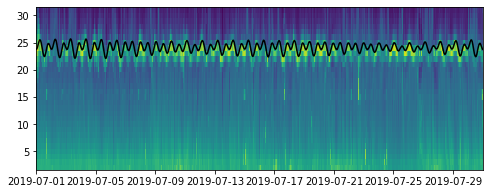

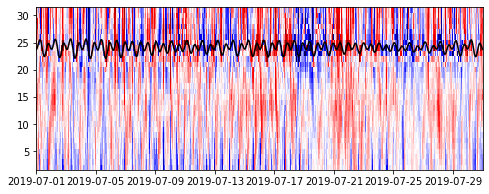

In [2]:
ds['u'] = ds['eastward_seawater_velocity']
ds['u'].attrs['units'] = 'm/s'

ds['v'] = ds['northward_seawater_velocity']
ds['v'].attrs['units'] = 'm/s'

#go from bins to depths
ds['bin_height'] = ds['depth_from_pressure'][0] - ds['bin_depths'][0,:]
ds['bin_height'].attrs['units'] = 'm'

ds['bin_depths_avg'] = ds['bin_height']-np.mean(ds['depth_from_pressure'])
ds['bin_depths_avg'].attrs['units'] = 'm'

ds['sea_surface'] = ds['depth_from_pressure']-np.mean(ds['depth_from_pressure'])
ds['sea_surface'].attrs['units'] = 'm'

ds['bottom_depth_avg'] = np.mean(ds['depth_from_pressure'])
ds['bottom_depth_avg'].attrs['units'] = 'm'

t1 = np.datetime64('2019-07-01 00:00:00')
t2 = np.datetime64('2019-07-31 00:00:00')

plt.figure(figsize=(8,3))
plt.pcolor(ds['time'],ds['bin_height'],
           ds['corrected_echo_intensity_beam1'].T, shading='auto')
plt.plot(ds['time'],ds['depth_from_pressure'],'k-')
plt.xlim([t1,t2])

plt.figure(figsize=(8,3))
plt.pcolor(ds['time'],ds['bin_height'],ds['u'].T,cmap='seismic', shading='auto')
plt.plot(ds['time'],ds['depth_from_pressure'],'k-') # convert from dPa to dbar
plt.clim([-0.4,0.4])
plt.xlim([t1,t2])

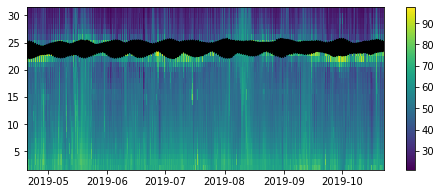

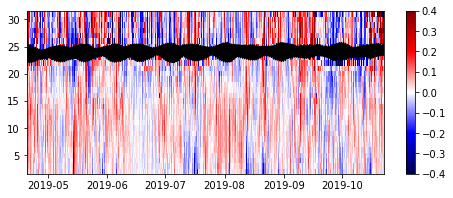

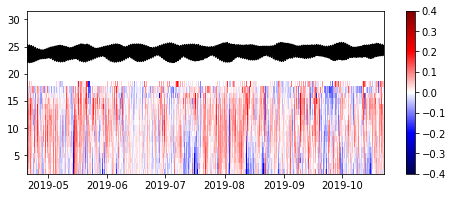

In [3]:
good = (ds['bin_depths'] > 7)

plt.figure(figsize=(8,3))
plt.pcolor(ds['time'],ds['bin_height'],
           ds['corrected_echo_intensity_beam1'].T, shading='auto')
plt.plot(ds['time'],ds['depth_from_pressure'],'k-')
plt.colorbar()

plt.figure(figsize=(8,3))
plt.pcolor(ds['time'],ds['bin_height'],ds['u'].T,cmap='seismic', shading='auto')
plt.plot(ds['time'],ds['depth_from_pressure'],'k-') # convert from dPa to dbar
plt.clim([-0.4,0.4])
plt.colorbar()

plt.figure(figsize=(8,3))
plt.pcolor(ds['time'],ds['bin_height'],ds['u'].where(good).T,cmap='seismic', shading='auto')
plt.plot(ds['time'],ds['depth_from_pressure'],'k-') # convert from dPa to dbar
plt.clim([-0.4,0.4])
plt.colorbar()

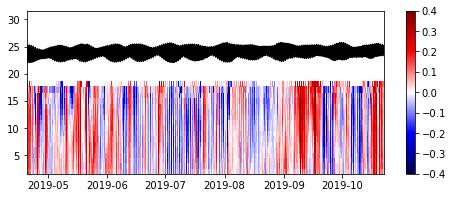

In [4]:
t1 = np.datetime64('2019-07-01 00:00:00')
t2 = np.datetime64('2019-07-15 00:00:00')

plt.figure(figsize=(8,3))
plt.pcolor(ds['time'],ds['bin_height'],ds['v'].where(good).T,cmap='seismic', shading='auto')
plt.plot(ds['time'],ds['depth_from_pressure'],'k-') # convert from dPa to dbar
plt.clim([-0.4,0.4])
plt.colorbar()

perform depth averaging using physoce time series

Text(0, 0.5, '[m/s]')

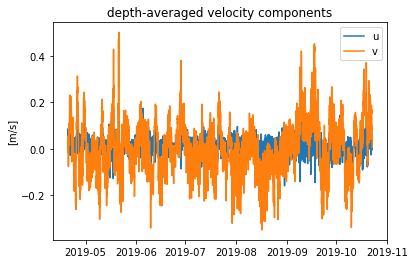

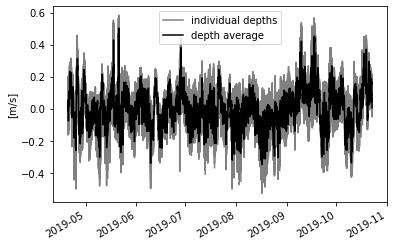

In [5]:
uda = ts.depthavg(ds['u'].where(good),
                  ds['bin_depths_avg'],
                  ds['bottom_depth_avg'],
                  ds['sea_surface'])

vda = ts.depthavg(ds['v'].where(good),
                  ds['bin_depths_avg'],
                  ds['bottom_depth_avg'],
                  ds['sea_surface'])

ds['uda'] = xr.DataArray(uda,dims='obs')
ds['uda'].attrs['units'] = 'm/s'
ds['vda'] = xr.DataArray(vda,dims='obs')
ds['vda'].attrs['units'] = 'm/s'

plt.figure()
plt.plot(ds['time'],ds['uda'])
plt.plot(ds['time'],ds['vda'])
plt.legend(['u','v'])
plt.title('depth-averaged velocity components')
plt.ylabel('[m/s]')

plt.figure()
h1 = plt.plot(ds['time'],ds['v'].where(good),color='gray', label='individual depths')
h1handle = mlines.Line2D([], [], color='gray', label='individual depths')
h2 = plt.plot(ds['time'],ds['vda'],color='k', label='depth average')
h2handle = mlines.Line2D([], [], color='k', label='depth average')
plt.gcf().autofmt_xdate()
plt.legend(handles=[h1handle, h2handle])
plt.ylabel('[m/s]')

rotate northern and eastern components into crossshore and alongshore directions using principal axis analysis

(18048.0, 18138.0)

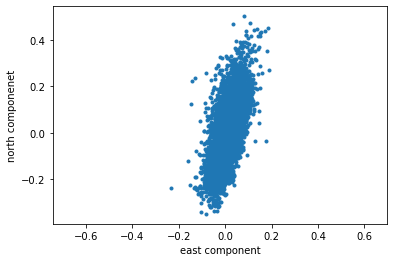

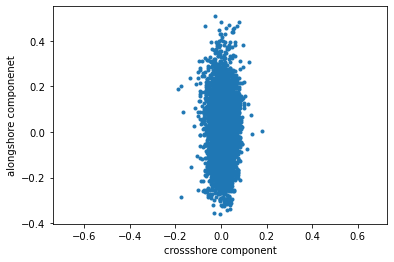

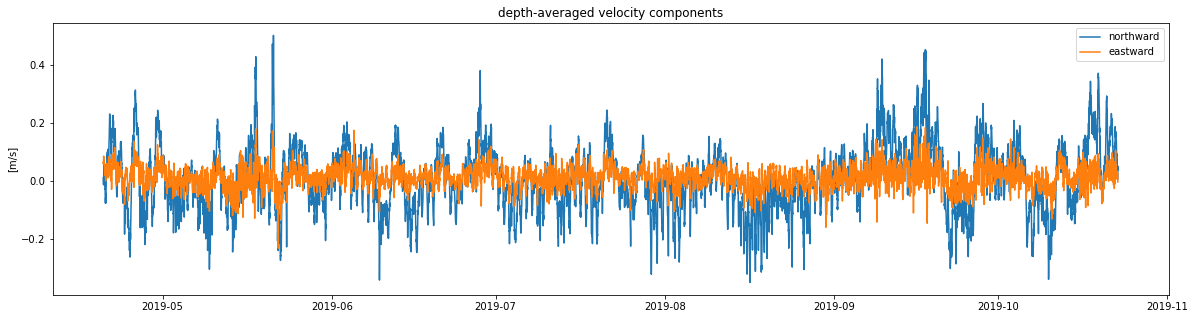

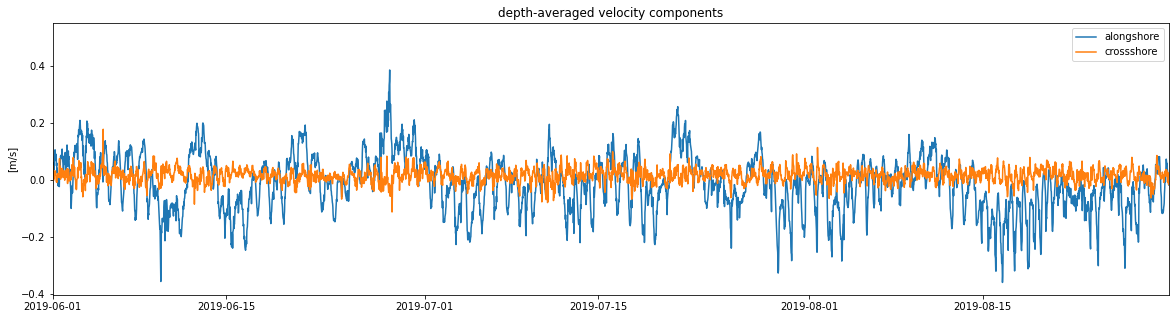

In [6]:

ncfile = 'http://thredds.dataexplorer.oceanobservatories.org/thredds/dodsC/ooigoldcopy/public/CE01ISSM-MFD35-04-ADCPTM000-recovered_inst-adcp_velocity_earth/deployment0011_CE01ISSM-MFD35-04-ADCPTM000-recovered_inst-adcp_velocity_earth.ncml'
ds = xr.open_dataset(ncfile)

ds['u'] = ds['eastward_seawater_velocity']
ds['u'].attrs['units'] = 'm/s'

ds['v'] = ds['northward_seawater_velocity']
ds['v'].attrs['units'] = 'm/s'

ds['bin_height'] = ds['depth_from_pressure'][0] - ds['bin_depths'][0,:]
ds['bin_height'].attrs['units'] = 'm'

ds['bin_depths_avg'] = ds['bin_height']-np.mean(ds['depth_from_pressure'])
ds['bin_depths_avg'].attrs['units'] = 'm'

ds['sea_surface'] = ds['depth_from_pressure']-np.mean(ds['depth_from_pressure'])
ds['sea_surface'].attrs['units'] = 'm'

ds['bottom_depth_avg'] = np.mean(ds['depth_from_pressure'])
ds['bottom_depth_avg'].attrs['units'] = 'm'

ds['bin_depths_avg']

uda = ts.depthavg(ds['u'].where(good),
                  ds['bin_depths_avg'],
                  ds['bottom_depth_avg'],
                  ds['sea_surface'])

vda = ts.depthavg(ds['v'].where(good),
                  ds['bin_depths_avg'],
                  ds['bottom_depth_avg'],
                  ds['sea_surface'])

ds['uda'] = xr.DataArray(uda,dims='obs')
ds['uda'].attrs['units'] = 'm/s'
ds['vda'] = xr.DataArray(vda,dims='obs')
ds['vda'].attrs['units'] = 'm/s'

theta,major,minor = princax(ds['uda'],ds['vda'])
ds['cs_da'],ds['as_da'] = rot(ds['uda'],ds['vda'],-theta+90)

t1 = np.datetime64('2019-06-01 00:00:00')
t2 = np.datetime64('2019-08-30 00:00:00')

plt.figure()
plt.plot(ds['uda'], ds['vda'], linestyle='none', marker='.')
plt.xlabel('east component')
plt.ylabel('north componenet')
plt.axis('equal')

plt.figure()
plt.plot(ds['cs_da'], ds['as_da'], linestyle='none', marker='.')
plt.xlabel('crossshore component')
plt.ylabel('alongshore componenet')
plt.axis('equal')

plt.figure(figsize=(20,5))
plt.plot(ds['time'],ds['vda'])
plt.plot(ds['time'],ds['uda'])
plt.legend(['northward','eastward'])
plt.title('depth-averaged velocity components')
plt.ylabel('[m/s]')

plt.figure(figsize=(20,5))
plt.plot(ds['time'],ds['as_da'])
plt.plot(ds['time'],ds['cs_da'])
plt.legend(['alongshore','crossshore'])
plt.title('depth-averaged velocity components')
plt.ylabel('[m/s]')
plt.xlim([t1,t2])

rotate, filter, and plot velocity data with pl64 from physoce time series

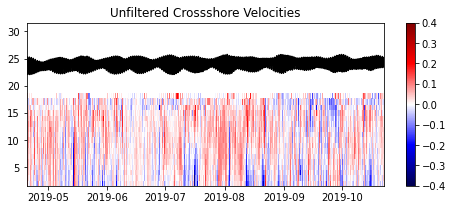

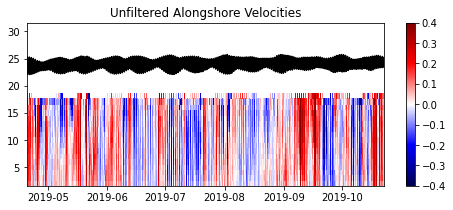

In [10]:
ds['cs'],ds['as'] = rot(ds['u'],ds['v'],-theta+90)

plt.figure(figsize=(8,3))
plt.pcolor(ds['time'],ds['bin_height'],ds['cs'].where(good).T,cmap='seismic', shading='auto')
plt.plot(ds['time'],ds['depth_from_pressure'],'k-') # convert from dPa to dbar
plt.clim([-0.4,0.4])
plt.title('Unfiltered Crossshore Velocities')
plt.colorbar()

plt.figure(figsize=(8,3))
plt.pcolor(ds['time'],ds['bin_height'],ds['as'].where(good).T,cmap='seismic', shading='auto')
plt.plot(ds['time'],ds['depth_from_pressure'],'k-') # convert from dPa to dbar
plt.clim([-0.4,0.4])
plt.title('Unfiltered Alongshore Velocities')
plt.colorbar()

In [53]:
#to perform filtering, first assign new data array with pl64 applied to each cross shore/along shore data
#then merge this data array with the main dataset
temp = xr.DataArray(ts.pl64(ds['cs']),coords=(ds['obs'],ds['bin']),dims=('obs','bin'),
                    name='cs_fil')
ds = ds.merge(temp)
temp = xr.DataArray(ts.pl64(ds['as']),coords=(ds['obs'],ds['bin']),dims=('obs','bin'),
                    name='as_fil')
ds = ds.merge(temp)

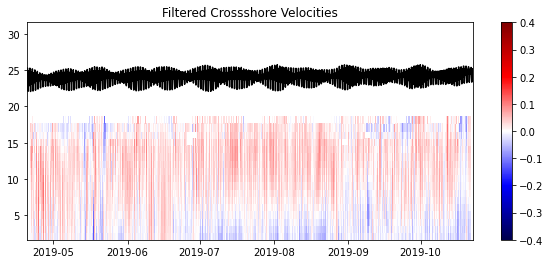

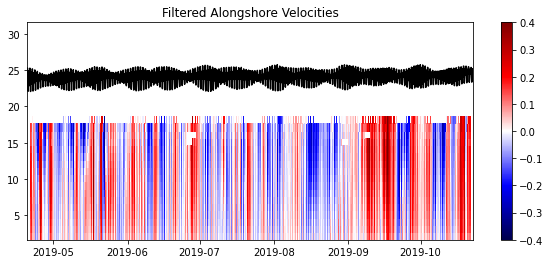

In [54]:
plt.figure(figsize=(10,4))
plt.pcolor(ds['time'],ds['bin_height'],ds['cs_fil'].where(good).T,cmap='seismic', shading='auto')
plt.plot(ds['time'],ds['depth_from_pressure'],'k-') # convert from dPa to dbar
plt.clim([-0.4,0.4])
plt.title('Filtered Crossshore Velocities')
plt.colorbar()

plt.figure(figsize=(10,4))
plt.pcolor(ds['time'],ds['bin_height'],ds['as_fil'].where(good).T,cmap='seismic', shading='auto')
plt.plot(ds['time'],ds['depth_from_pressure'],'k-') # convert from dPa to dbar
plt.clim([-0.4,0.4])
plt.title('Filtered Alongshore Velocities')
plt.colorbar()

Now time to work on finding baroclinic u, with depth average removed and filter applied. (only in crossshore direction)

Taking baroclinic crossshore velocity as the filtered velocity minus (should it be plus?) the depth average.

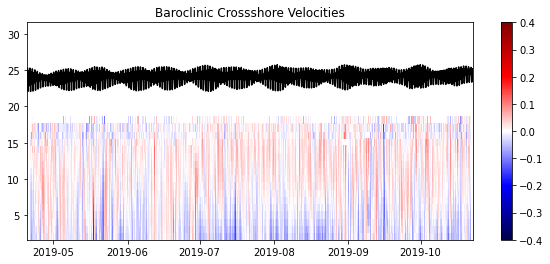

In [61]:
ds['cs_bar'] = ds['cs_fil'] - ds['cs_da']

plt.figure(figsize=(10,4))
plt.pcolor(ds['time'],ds['bin_height'],ds['cs_bar'].where(good).T,cmap='seismic', shading='auto')
plt.plot(ds['time'],ds['depth_from_pressure'],'k-') # convert from dPa to dbar
plt.clim([-0.4,0.4])
plt.title('Baroclinic Crossshore Velocities')
plt.colorbar()

(18048.0, 18138.0)

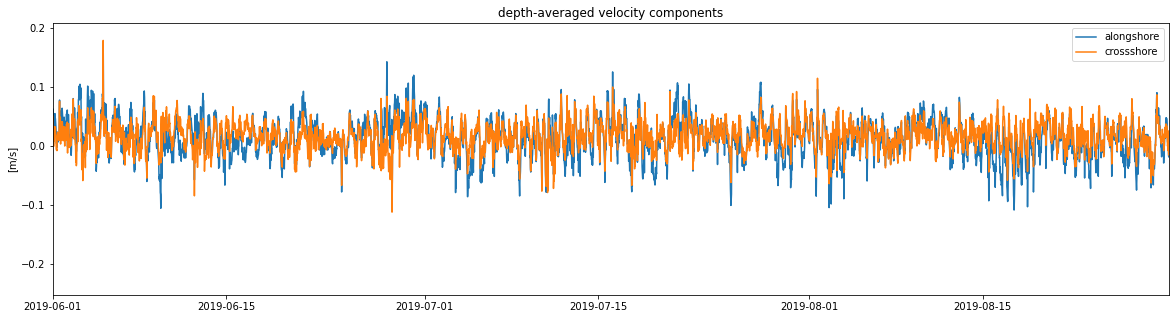

In [62]:
test = ts.depthavg(ds['cs_bar'].where(good),
                  ds['bin_depths_avg'],
                  ds['bottom_depth_avg'],
                  ds['sea_surface'])
ds['test'] = xr.DataArray(uda,dims='obs')
ds['test'].attrs['units'] = 'm/s'

plt.figure(figsize=(20,5))
plt.plot(ds['time'],ds['test'])
plt.plot(ds['time'],ds['cs_da'])
plt.legend(['alongshore','crossshore'])
plt.title('Crossshore depth average after depth average and filter correction is applied')
plt.ylabel('[m/s]')
plt.xlim([t1,t2])

begin wind analysis for qualitative comparison

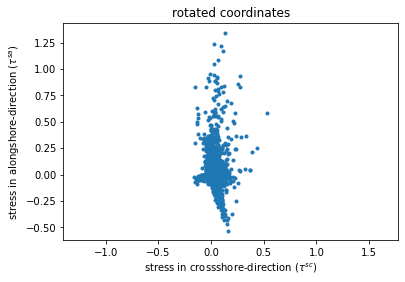

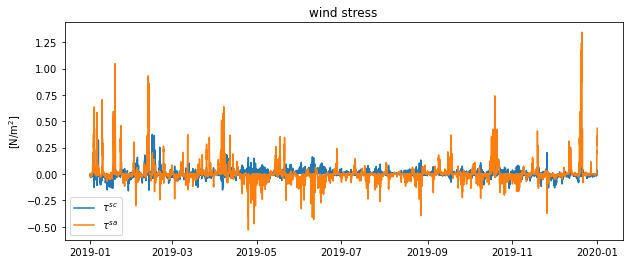

In [68]:
def wind_uv_from_spddir(wspd,wdir):
    theta = np.array(wdir)
    theta = theta*np.pi/180
    x = np.sin(theta)
    y = np.cos(theta)
    theta_cart = np.arctan2(y,x)
    u = -wspd*np.cos(theta_cart) #why should these be negative?
    v = -wspd*np.sin(theta_cart)
    return u,v

ncfile = 'https://dods.ndbc.noaa.gov/thredds/dodsC/data/stdmet/nwpo3/nwpo3h2019.nc'
ds_wind = xr.open_dataset(ncfile)

ds_wind = ds_wind.squeeze()

#get and plot alignment of wind velocity 

ds_wind['wind_east'],ds_wind['wind_north'] = wind_uv_from_spddir(ds_wind['wind_spd'], ds_wind['wind_dir'])

tau = stress(ds_wind['wind_spd'],z=4.1)
#wind stress in same direction as wind velocity, so get theta from arctan2 then use this to find components of tau
tau_east = tau*np.cos(np.arctan2(ds_wind['wind_north'],ds_wind['wind_east']))
tau_north = tau*np.sin(np.arctan2(ds_wind['wind_north'],ds_wind['wind_east']))

ds_wind['tau_east'] = (('time'), tau_east)
ds_wind['tau_north'] = (('time'), tau_north)

#rotate vectors to be in alongshore & crossshore direction
theta,major,minor = princax(ds_wind['tau_east'],ds_wind['tau_north']) #rot angle is CCW rotation for vecotr or CW rotation for basis
ds_wind['tau_x'],ds_wind['tau_y'] = rot(ds_wind['tau_east'],ds_wind['tau_north'],-theta+90)

plt.figure()
plt.plot(ds_wind['tau_x'],ds_wind['tau_y'],'.')
plt.axis('equal')
plt.xlabel('stress in crossshore-direction ($\\tau^{sc}$)')
plt.ylabel('stress in alongshore-direction ($\\tau^{sa}$)')
plt.title('rotated coordinates')


plt.figure(figsize=(10,4))
plt.plot(ds_wind['time'],ds_wind['tau_x'])
plt.plot(ds_wind['time'],ds_wind['tau_y'])
plt.ylabel('[N/m$^2$]')
plt.title('wind stress')
plt.legend(['$\\tau^{sc}$','$\\tau^{sa}$'])

plotting above wind/water current plots for easier comparison

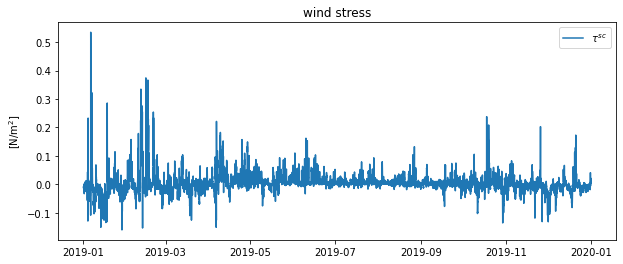

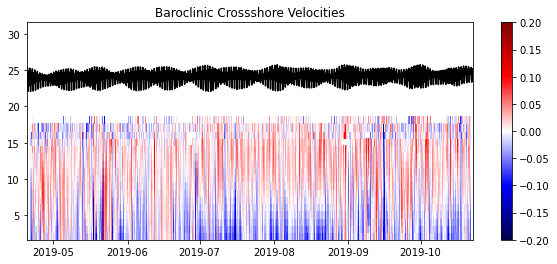

In [78]:
plt.figure(figsize=(10,4))
plt.plot(ds_wind['time'],ds_wind['tau_x'])
plt.ylabel('[N/m$^2$]')
plt.title('wind stress')
plt.legend(['$\\tau^{sc}$','$\\tau^{sa}$'])

plt.figure(figsize=(10,4))
plt.pcolor(ds['time'],ds['bin_height'],ds['cs_bar'].where(good).T,cmap='seismic', shading='auto')
plt.plot(ds['time'],ds['depth_from_pressure'],'k-') # convert from dPa to dbar
plt.clim([-0.2,0.2])
plt.title('Baroclinic Crossshore Velocities')
plt.colorbar()

looking at return and offshore flow time series specifically (bin heights ~3m and 13m above bottom, respectively):

(-0.15, 0.15)

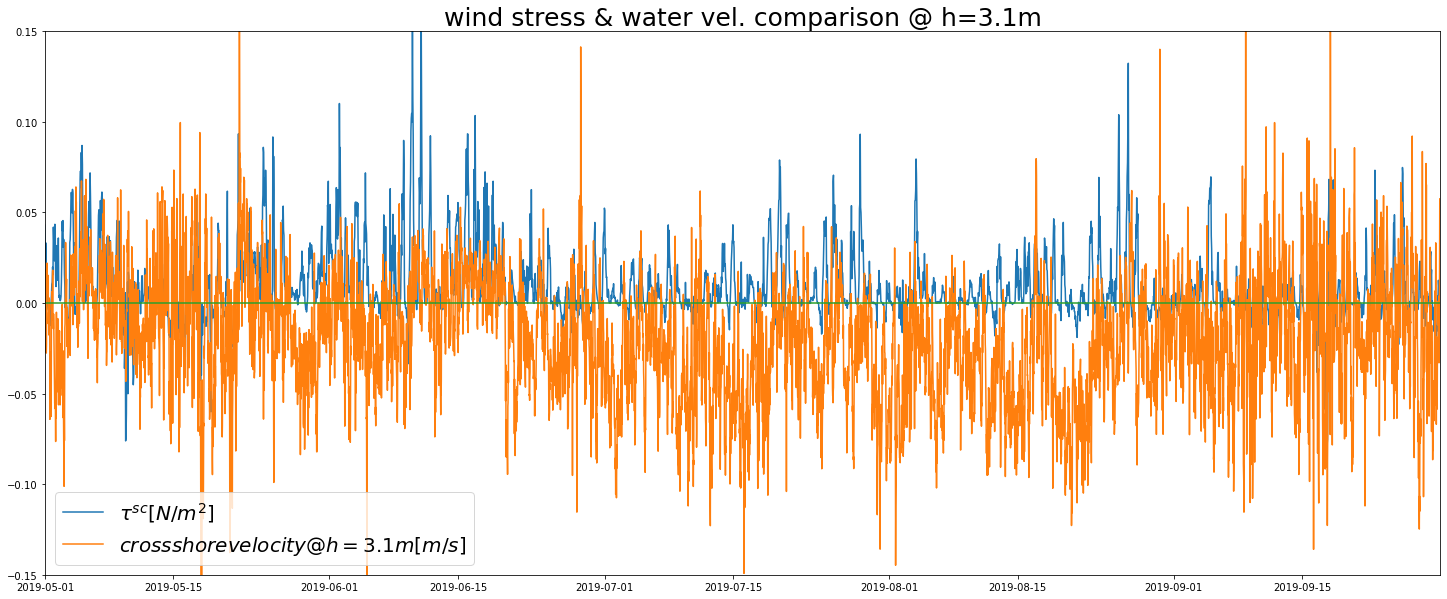

In [113]:
t1 = np.datetime64('2019-05-01 00:00:00')
t2 = np.datetime64('2019-09-30 00:00:00')

zero = np.zeros(len(ds['time']))

plt.figure(figsize=(25,10))
plt.plot(ds_wind['time'],ds_wind['tau_x'])
plt.title('wind stress & water vel. comparison @ h=3.1m', fontsize=25)
plt.plot(ds['time'],ds['cs_bar'].T[1])
plt.plot(ds['time'],zero)
plt.legend(['$\\tau^{sc} [N/m^2]$','$crossshore velocity @ h=3.1m [m/s]$'], prop={'size': 20}, loc=3)
plt.xlim([t1,t2])
plt.ylim([-0.15,0.15])


(-0.15, 0.15)

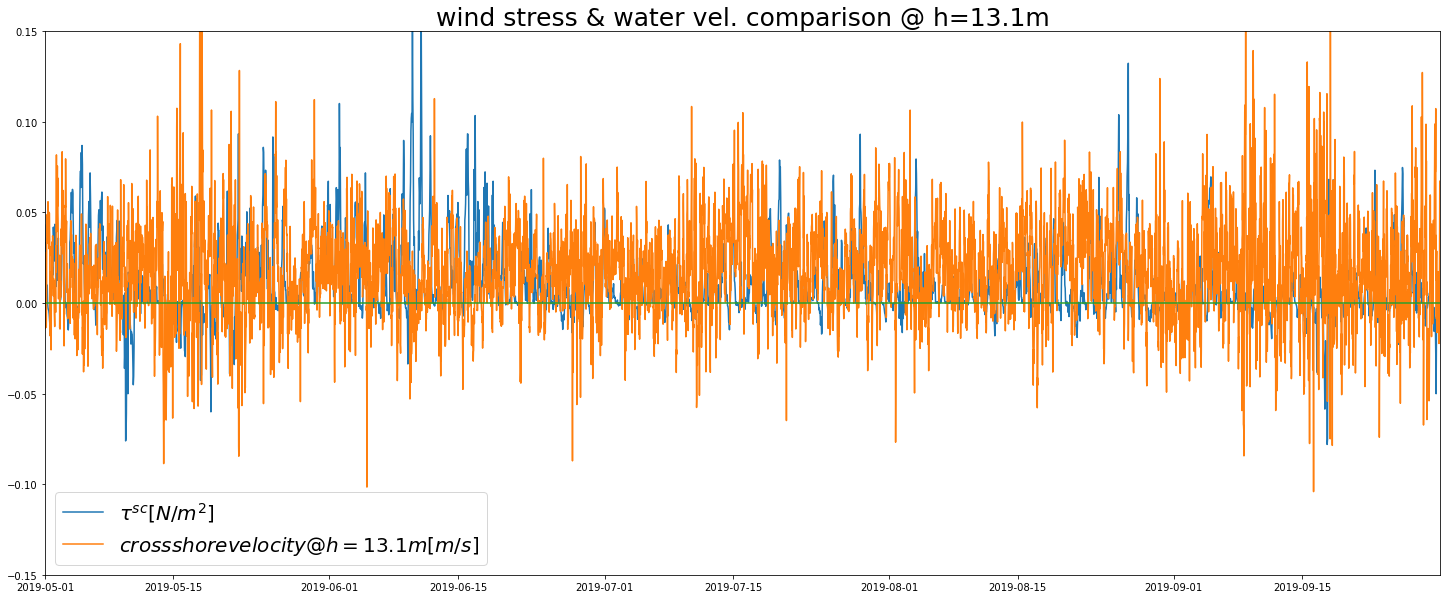

In [112]:
plt.figure(figsize=(25,10))
plt.plot(ds_wind['time'],ds_wind['tau_x'])
plt.title('wind stress & water vel. comparison @ h=13.1m', fontsize=25)
plt.plot(ds['time'],ds['cs_bar'].T[11])
plt.plot(ds['time'],zero)
plt.legend(['$\\tau^{sc} [N/m^2]$','$crossshore velocity @ h=13.1m [m/s]$'], prop={'size': 20}, loc=3)
plt.xlim([t1,t2])
plt.ylim([-0.15,0.15])

It seems like the above is more consistent with downwelling behavior for the majority of the summer, at least at the near shore location. I think the data is analyzed correctly and it seems to be consistent with the earlier color map graphs we have seen. 